The purpose of this program it to pull image files from segments.ai and save them to a local folder of the users choice. This program will also take the instance and semantic data from segments.ai and use it to generate instance and semantic bitmap files and store them in the same directory as the original file.

## Import Libraries

In [29]:
import os
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
from segments.utils import load_image_from_url, load_label_bitmap_from_url, get_semantic_bitmap
from segments import SegmentsClient
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.16.1


## Setup data transfer
This section utilizes a locally saved version of the Segments.ai API key to pull the data from their website.

In [30]:
# Use your Segments.ai API key
API_folder = "C:/Users/alex/Desktop/API_keys/" # Change this to the folder where you saved your API key
API_file = "Segments_API.txt" # Change this to the name of your API key file
api_key = open(API_folder + API_file, "r").readline().strip()
client = SegmentsClient(api_key)
dataset_identifier = 'davis_alexander/TEM_Project1' # Change this to your username/dataset_name
dataset = client.get_dataset(dataset_identifier)
segments_data = client.get_samples(dataset_identifier)

## Load COCO-instance file
The COCO-instance.json file is generated by coco_format_splitter.ipynb. Make sure to run that file first.

In [31]:
# Load the COCO JSON file
coco_file = './coco_format_dataset.json'
with open(coco_file, 'r') as f:
    coco_data = json.load(f)

# Verify the loaded data
print(coco_data.keys())

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])


In [32]:
def get_coco_data(file_name):
    for index, image in enumerate(coco_data['images']):
        if image['file_name'] == file_name:
            return image, coco_data['annotations'][index]

    return None

In [33]:
def image_splitter(sample):
    """
    This function takes a sample from the Segments.ai dataset and returns the image, instance bitmap, semantic bitmap, and COCO annotations.

    Parameters:
        sample (segments.Sample): The sample to be processed.
    
    """
    label = client.get_label(sample.uuid, labelset='ground-truth')

    # Load the labels as numpy arrays
    image = load_image_from_url(sample.attributes.image.url)
    instance_bitmap = load_label_bitmap_from_url(label.attributes.segmentation_bitmap.url)

    coco_image_data, coco_annotations = get_coco_data(sample.name)

    # Convert annotations to dictionaries if they are objects
    annotations = [annotation.__dict__ for annotation in label.attributes.annotations]

    # Generate semantic bitmap
    semantic_bitmap = get_semantic_bitmap(instance_bitmap, annotations)
    return image, instance_bitmap, semantic_bitmap, coco_image_data, coco_annotations, sample.name

### Verify that the correct images are generated

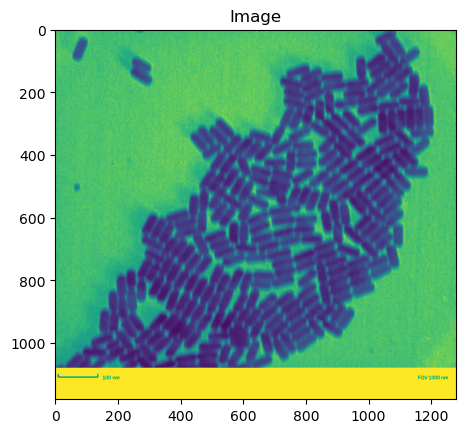

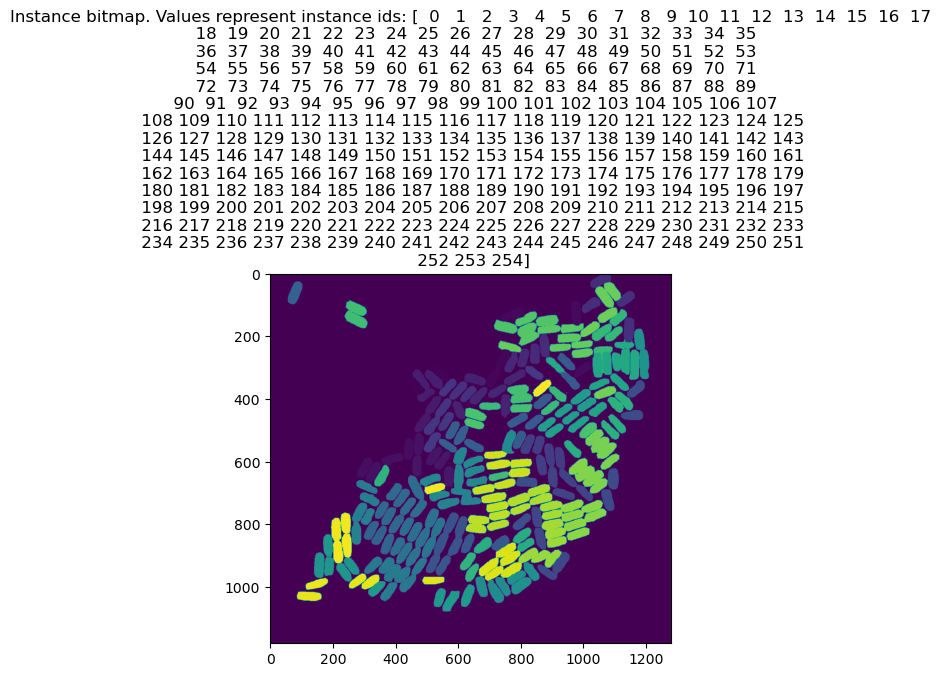

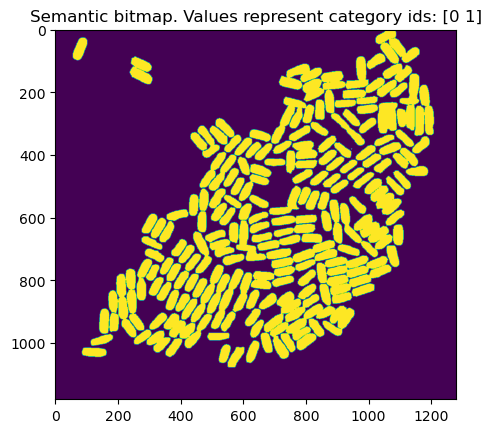

{'id': 23, 'image_id': 1, 'category_id': 1, 'segmentation': [[1030, 652, 1029, 653, 1028, 653, 1027, 654, 1027, 655, 1026, 656, 1026, 658, 1025, 659, 1025, 660, 1024, 661, 1024, 664, 1023, 665, 1023, 666, 1022, 667, 1022, 675, 1024, 677, 1024, 678, 1027, 681, 1029, 681, 1030, 682, 1032, 682, 1033, 683, 1034, 683, 1035, 684, 1036, 684, 1037, 685, 1039, 685, 1040, 686, 1041, 686, 1043, 688, 1048, 688, 1049, 689, 1053, 689, 1054, 690, 1058, 690, 1059, 691, 1062, 691, 1063, 692, 1068, 692, 1069, 693, 1069, 694, 1073, 694, 1074, 695, 1078, 695, 1079, 696, 1084, 696, 1085, 697, 1089, 697, 1090, 698, 1094, 698, 1095, 699, 1099, 699, 1100, 700, 1105, 700, 1106, 701, 1110, 701, 1111, 700, 1112, 700, 1113, 699, 1114, 699, 1119, 694, 1119, 692, 1120, 691, 1120, 689, 1121, 688, 1121, 683, 1120, 682, 1120, 680, 1119, 679, 1119, 676, 1112, 669, 1108, 669, 1107, 668, 1104, 668, 1103, 667, 1101, 667, 1100, 666, 1095, 666, 1094, 665, 1091, 665, 1090, 664, 1087, 664, 1086, 663, 1082, 663, 1081, 662, 108

In [34]:
image, instance_bitmap, semantic_bitmap, coco_image_data, coco_annotations, name = image_splitter(segments_data[3])
# Visualize
plt.imshow(image)
plt.title('Image')
plt.show()

plt.imshow(instance_bitmap)
plt.title(f'Instance bitmap. Values represent instance ids: {np.unique(instance_bitmap)}')
plt.show()

plt.imshow(semantic_bitmap)
plt.title(f'Semantic bitmap. Values represent category ids: {np.unique(semantic_bitmap)}')
plt.show()

print(coco_annotations)

## Data Exportation

In [35]:
dataset_length = len(segments_data)
indices = np.arange(dataset_length)

# Select folder to save images
output_folder = './data/images/all'
os.makedirs(output_folder, exist_ok=True)

def process_and_save(indices):
    """
    Process and save images to the output folder. Generates three images for each sample: the original image, the instance bitmap, and the semantic bitmap.

    Parameters:
        indices (numpy.ndarray): The indices of the samples to be processed.
    """
    
    for i in indices:
        image, instance_bitmap, semantic_bitmap, coco_image_data, coco_annotations, name = image_splitter(segments_data[i])
        
        # Save images
        plt.imsave(os.path.join(output_folder, f'{name[:-4]}.jpg'), image, cmap='gray')
        plt.imsave(os.path.join(output_folder, f'{name[:-4]}_instance.jpg'), instance_bitmap, cmap='viridis')
        plt.imsave(os.path.join(output_folder, f'{name[:-4]}_semantic.jpg'), semantic_bitmap, cmap='coolwarm')

process_and_save(indices)